In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gensim.models import KeyedVectors
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import sys
from pathlib import Path


# 设置更好的可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
# 假设notebooks目录在项目根目录下
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from src.utils import download_chinese_font
import src.utils as utils
# 下载并安装字体
font_path = download_chinese_font()

# 设置matplotlib使用下载的字体
if font_path:
    plt.rcParams['font.sans-serif'] = ['SimHei'] + plt.rcParams['font.sans-serif']
    print("成功设置中文字体")
else:
    print("无法设置中文字体，将使用替代方案")

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


# 测试中文显示
# plt.figure(figsize=(6, 4))
# plt.title("中文测试")
# plt.text(0.5, 0.5, "法治", fontsize=20, ha='center')
# plt.axis('off')
# plt.show()

# 定义项目根目录和模型目录
PROJECT_ROOT = Path.cwd().parent
MODELS_DIR = PROJECT_ROOT / "models"

# 可能的模型目录
FINE_TUNED_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_flexible"
SLIDING_WINDOW_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_sliding_window"

# 检查哪个目录存在并包含模型
if FINE_TUNED_MODELS_DIR.exists() and any(FINE_TUNED_MODELS_DIR.glob("*_wordvectors.kv")):
    MODELS_DIR = FINE_TUNED_MODELS_DIR
    print(f"使用固定时期模型目录: {MODELS_DIR}")
elif SLIDING_WINDOW_MODELS_DIR.exists():
    # 查找滑动窗口模型的子目录
    subdirs = [d for d in SLIDING_WINDOW_MODELS_DIR.iterdir() if d.is_dir()]
    if subdirs:
        MODELS_DIR = subdirs[0]  # 使用第一个子目录
        print(f"使用滑动窗口模型目录: {MODELS_DIR}")
    else:
        print(f"滑动窗口模型目录存在，但没有子目录")
else:
    print(f"未找到模型目录，使用默认路径: {MODELS_DIR}")

# 加载所有可用的模型
def load_models():
    """加载目录中所有的词向量模型"""
    models = {}
    model_files = list(MODELS_DIR.glob("*_wordvectors.kv"))
    
    if not model_files:
        print(f"在 {MODELS_DIR} 中没有找到模型文件")
        return models
    
    print(f"找到 {len(model_files)} 个模型文件:")
    for model_file in sorted(model_files):
        period_name = model_file.stem.replace("_wordvectors", "")
        print(f"  加载模型: {period_name}")
        try:
            models[period_name] = KeyedVectors.load(str(model_file))
            print(f"  成功加载 {period_name}, 词汇量: {len(models[period_name].index_to_key)}")
        except Exception as e:
            print(f"  加载 {period_name} 失败: {e}")
    
    return models

# 加载模型
models = load_models()

# 检查模型是否成功加载
if not models:
    print("没有成功加载任何模型，请检查模型路径")
else:
    print(f"\n成功加载了 {len(models)} 个模型:")
    for period_name, model in models.items():
        print(f"  {period_name}: 词汇量 {len(model.index_to_key)}")

字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体
使用固定时期模型目录: /home/fangshikai/law-word-vector/models/fine_tuned_vectors_flexible
找到 3 个模型文件:
  加载模型: Era1_1978-1996
  成功加载 Era1_1978-1996, 词汇量: 4874
  加载模型: Era2_1997-2013
  成功加载 Era2_1997-2013, 词汇量: 4992
  加载模型: Era3_2014-2024
  成功加载 Era3_2014-2024, 词汇量: 5000

成功加载了 3 个模型:
  Era1_1978-1996: 词汇量 4874
  Era2_1997-2013: 词汇量 4992
  Era3_2014-2024: 词汇量 5000


In [6]:

# 使用示例
# save_similar_words(models, keyword="法制", topn=5000, output_dir="similar_words")


In [7]:
models

{'Era1_1978-1996': <gensim.models.keyedvectors.KeyedVectors at 0x7ad1b0a6cd90>,
 'Era2_1997-2013': <gensim.models.keyedvectors.KeyedVectors at 0x7ad1b0a6c490>,
 'Era3_2014-2024': <gensim.models.keyedvectors.KeyedVectors at 0x7ad1b0a84b80>}

In [18]:
def visualize_similar_words_across_periods(similar_words_by_period, focus_word, top_n=20, exclude_words_path=None, normalize=False):
    """
    可视化不同时期相似词的变化
    
    参数:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    focus_word: 焦点词
    top_n: 每个时期要显示的前N个相似词
    exclude_words_path: 排除词库的文件路径，文件中每行一个词
    """
    if not similar_words_by_period:
        print("没有数据可供可视化")
        return
    
    # 加载排除词库
    exclude_words = set()
    if exclude_words_path:
        try:
            with open(exclude_words_path, 'r', encoding='utf-8') as f:
                exclude_words = set(line.strip() for line in f if line.strip())
            print(f"已加载 {len(exclude_words)} 个排除词")
        except Exception as e:
            print(f"加载排除词库时出错: {e}")
    
    # 准备数据
    periods = list(similar_words_by_period.keys())
    
    # 创建一个包含所有时期前top_n个相似词的列表（排除指定词）
    all_top_words = []
    
    # 首先，为每个时期过滤掉排除词
    filtered_similar_words = {}
    for period in periods:
        # 过滤掉排除词
        filtered_words = [(word, sim) for word, sim in similar_words_by_period[period] 
                         if word not in exclude_words]
        filtered_similar_words[period] = filtered_words
    
    # 然后，从过滤后的列表中获取前top_n个词
    for period in periods:
        top_words = [word for word, _ in filtered_similar_words[period][:top_n]]
        for word in top_words:
            if word not in all_top_words:  # 避免重复
                all_top_words.append(word)
    
    # 如果没有词语可以显示，则返回
    if not all_top_words:
        print("过滤后没有词语可以显示")
        return None
    
    # 创建一个DataFrame来存储每个时期每个词的相似度
    df = pd.DataFrame(index=all_top_words, columns=periods)
    
    # 填充DataFrame
    for period in periods:
        word_sim_dict = dict(filtered_similar_words[period])
        for word in all_top_words:
            df.loc[word, period] = word_sim_dict.get(word, 0)
        if normalize:
            sum_sim = sum(sim for word, sim in filtered_similar_words[period])
            filtered_similar_words[period] = [(word, sim / sum_sim) for word, sim in filtered_similar_words[period]]
    
    # 确保所有值都是浮点数
    df = df.astype(float)
    
    # 按照在最后一个时期的相似度排序
    if len(periods) > 0:
        last_period = periods[-1]
        df = df.sort_values(by=last_period, ascending=False)
    
    # 绘制热力图
    plt.figure(figsize=(12, len(all_top_words) * 0.3 + 2))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
    plt.title(f"与'{focus_word}'相似度最高的{top_n}个词在不同时期的变化（已排除{len(exclude_words)}个词）")
    plt.tight_layout()
    plt.show()
    
    return df

In [10]:
def load_expert_word_list(file_path):
    """
    加载专家选取的关键词和相似度
    
    Args:
        file_path: 专家词列表文件路径
        
    Returns:
        list: 专家词列表，值为(word, similarity)元组列表
    """
    result = []
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            # 跳过文件的第一行（通常是标题或注释）
            next(f, None)
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = line.split()
                    if len(parts) >= 2:
                        word = parts[0]
                        # 尝试将最后一个部分转换为浮点数作为相似度
                        try:
                            similarity = float(parts[-1])
                            result.append((word, similarity))
                        except ValueError:
                            # 如果转换失败，假设没有相似度值，设为0
                            result.append((word, 0.0))
                    elif len(parts) == 1:
                        # 只有词没有相似度
                        result.append((parts[0], 0.0))
        return result
    except Exception as e:
        print(f"读取专家词表出错: {e}")
        return []


# 定义各时期词表文件路径
era_files = {
    'Era1_1978-1996': 'similar_words/Era1_1978-1996_final.txt',
    'Era2_1997-2013': 'similar_words/Era2_1997-2013_final.txt',
    'Era3_2014-2024': 'similar_words/Era3_2014-2024_final.txt'
}

# 读取所有时期的词表
similar_words_by_period = {}
for era, file_path in era_files.items():
    word_list = load_expert_word_list(file_path)
    if word_list:
        print(f"已加载 {era} 词表，包含 {len(word_list)} 个词")
        similar_words_by_period[era] = word_list
    else:
        print(f"警告: {era} 词表为空")



已加载 Era1_1978-1996 词表，包含 150 个词
已加载 Era2_1997-2013 词表，包含 150 个词
已加载 Era3_2014-2024 词表，包含 150 个词


In [11]:
def update_sim(models, similar_words_by_period, focus_word):
    """
    根据模型更新similar_words_by_period中的相似度值
    
    参数:
    models: 词向量模型字典，键为时期名称，值为KeyedVectors模型
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    focus_word: 中心词，用于计算相似度的参考词
    
    返回:
    updated_similar_words: 更新后的相似词字典
    """
    updated_similar_words = {}
    
    for period, word_list in similar_words_by_period.items():
        if period not in models:
            print(f"警告: 找不到{period}的模型，跳过更新")
            updated_similar_words[period] = word_list
            continue
            
        model = models[period]
        
        # 检查中心词是否在模型中
        if focus_word not in model:
            print(f"警告: 中心词'{focus_word}'在{period}模型中不存在，跳过更新")
            updated_similar_words[period] = word_list
            continue
        
        # 更新相似度
        updated_list = []
        for word, _ in word_list:
            if word in model:
                # 计算与中心词的相似度
                similarity = model.similarity(focus_word, word)
                updated_list.append((word, similarity))
            else:
                print(f"警告: 词'{word}'在{period}模型中不存在，保留原始相似度")
                # 找到原始相似度
                original_sim = next((sim for w, sim in word_list if w == word), 0.0)
                updated_list.append((word, original_sim))
        
        updated_similar_words[period] = updated_list
        print(f"已更新 {period} 的相似度值，共 {len(updated_list)} 个词")
    
    return updated_similar_words


def build_similar_words_by_period_from_word_list(models, focus_word, target_word_list, ):
    """
    根据目标词列表构建各时期的相似词字典
    
    参数:
    models: 词向量模型字典，键为时期名称，值为KeyedVectors模型
    focus_word: 中心词，用于计算相似度的参考词
    target_word_list: 目标词列表，将计算这些词与中心词的相似度
    返回:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    """
    similar_words_by_period = {}
    
    for period, model in models.items():
        # 检查中心词是否在模型中
        if focus_word not in model:
            print(f"警告: 中心词'{focus_word}'在{period}模型中不存在，跳过该时期")
            similar_words_by_period[period] = []
            continue
        
        # 计算目标词列表中每个词与中心词的相似度
        period_similar_words = []
        for word in target_word_list:
            # 跳过关键词自己
            if word == focus_word:
                continue
            if word in model:
                similarity = model.similarity(focus_word, word)
                period_similar_words.append((word, similarity))
            else:
                print(f"警告: 词'{word}'在{period}模型中不存在，设置为0")
                period_similar_words.append((word, 0))
        
        # 按相似度降序排序
        period_similar_words.sort(key=lambda x: x[1], reverse=True)
        # if normalize:
        #     sum_sim = sum(sim for word, sim in period_similar_words)
        #     period_similar_words = [(word, sim / sum_sim) for word, sim in period_similar_words]
        similar_words_by_period[period] = period_similar_words
        print(f"已为 {period} 构建相似词列表，共 {len(period_similar_words)} 个词")
    
    return similar_words_by_period

def get_word_sets(similar_words_by_period, top_n=50, exclude_words_path=None):
    """
    获取不同时期词表的交集和并集
    
    参数:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    top_n: 每个时期要考虑的前N个相似词
    exclude_words_path: 排除词库的文件路径，文件中每行一个词

    返回:
    intersection: 所有时期前N个相似词的交集
    union: 所有时期前N个相似词的并集
    filtered_similar_words: 过滤后的相似词字典
    """
    if not similar_words_by_period:
        print("没有数据可供分析")
        return set(), set(), {}
    
    # 加载排除词库
    exclude_words = set()
    if exclude_words_path:
        try:
            with open(exclude_words_path, 'r', encoding='utf-8') as f:
                exclude_words = set(line.strip() for line in f if line.strip())
            print(f"已加载 {len(exclude_words)} 个排除词")
        except Exception as e:
            print(f"加载排除词库时出错: {e}")
    
    # 过滤并获取每个时期的前N个词
    filtered_similar_words = {}
    word_sets = []
    
    for period, word_list in similar_words_by_period.items():
        # 按相似度排序
        sorted_words = sorted(word_list, key=lambda x: x[1], reverse=True)
        
        # 过滤掉排除词
        filtered_words = [(word, sim) for word, sim in sorted_words if word not in exclude_words]
        
        # 取前N个
        top_words = filtered_words[:top_n]
        filtered_similar_words[period] = top_words
        
        # 提取词汇集合
        word_set = set(word for word, _ in top_words)
        word_sets.append(word_set)
        
        print(f"{period}: 过滤后保留 {len(top_words)} 个词")
    
    # 计算交集和并集
    if word_sets:
        intersection = set.intersection(*word_sets)
        union = set.union(*word_sets)
        print(f"所有时期共有词: {len(intersection)} 个")
        print(f"所有时期词汇并集: {len(union)} 个")
    else:
        intersection = set()
        union = set()
        print("没有可用的词集合")
    
    return list(intersection), list(union), filtered_similar_words


# similar_words_by_period = update_sim
intersection, union, filtered_similar_words = get_word_sets(similar_words_by_period, top_n=150, exclude_words_path="exclude_words.txt")
# similar_words_by_period_union = build_similar_words_by_period_from_word_list(models, "法治",union )

similar_words_by_period_intersection = build_similar_words_by_period_from_word_list(models, "法治",intersection ,)
similar_words_by_period_union = build_similar_words_by_period_from_word_list(models, "法治",union )


已加载 17 个排除词
Era1_1978-1996: 过滤后保留 149 个词
Era2_1997-2013: 过滤后保留 148 个词
Era3_2014-2024: 过滤后保留 148 个词
所有时期共有词: 41 个
所有时期词汇并集: 284 个
已为 Era1_1978-1996 构建相似词列表，共 41 个词
已为 Era2_1997-2013 构建相似词列表，共 41 个词
已为 Era3_2014-2024 构建相似词列表，共 41 个词
警告: 词'依宪'在Era1_1978-1996模型中不存在，设置为0
警告: 词'程序化'在Era1_1978-1996模型中不存在，设置为0
警告: 词'行使职权'在Era1_1978-1996模型中不存在，设置为0
警告: 词'善治'在Era1_1978-1996模型中不存在，设置为0
警告: 词'法治政府'在Era1_1978-1996模型中不存在，设置为0
警告: 词'社会公德'在Era1_1978-1996模型中不存在，设置为0
警告: 词'教育引导'在Era1_1978-1996模型中不存在，设置为0
警告: 词'依宪治国'在Era1_1978-1996模型中不存在，设置为0
警告: 词'司法公正'在Era1_1978-1996模型中不存在，设置为0
警告: 词'和谐'在Era1_1978-1996模型中不存在，设置为0
警告: 词'法理'在Era1_1978-1996模型中不存在，设置为0
警告: 词'人文环境'在Era1_1978-1996模型中不存在，设置为0
警告: 词'根本法'在Era1_1978-1996模型中不存在，设置为0
警告: 词'监督者'在Era1_1978-1996模型中不存在，设置为0
警告: 词'民族事务'在Era1_1978-1996模型中不存在，设置为0
警告: 词'实效性'在Era1_1978-1996模型中不存在，设置为0
警告: 词'行政效率'在Era1_1978-1996模型中不存在，设置为0
警告: 词'崇法'在Era1_1978-1996模型中不存在，设置为0
警告: 词'以民为本'在Era1_1978-1996模型中不存在，设置为0
警告: 词'营商'在Era1_1978-1996模型中不存在，设置为0
警告: 词'产权保护'在Era1_1978-199

In [7]:
# 创建一个示例排除词库文件
exclude_words_path = "exclude_words.txt"
focus_word = "法治"

已加载 17 个排除词


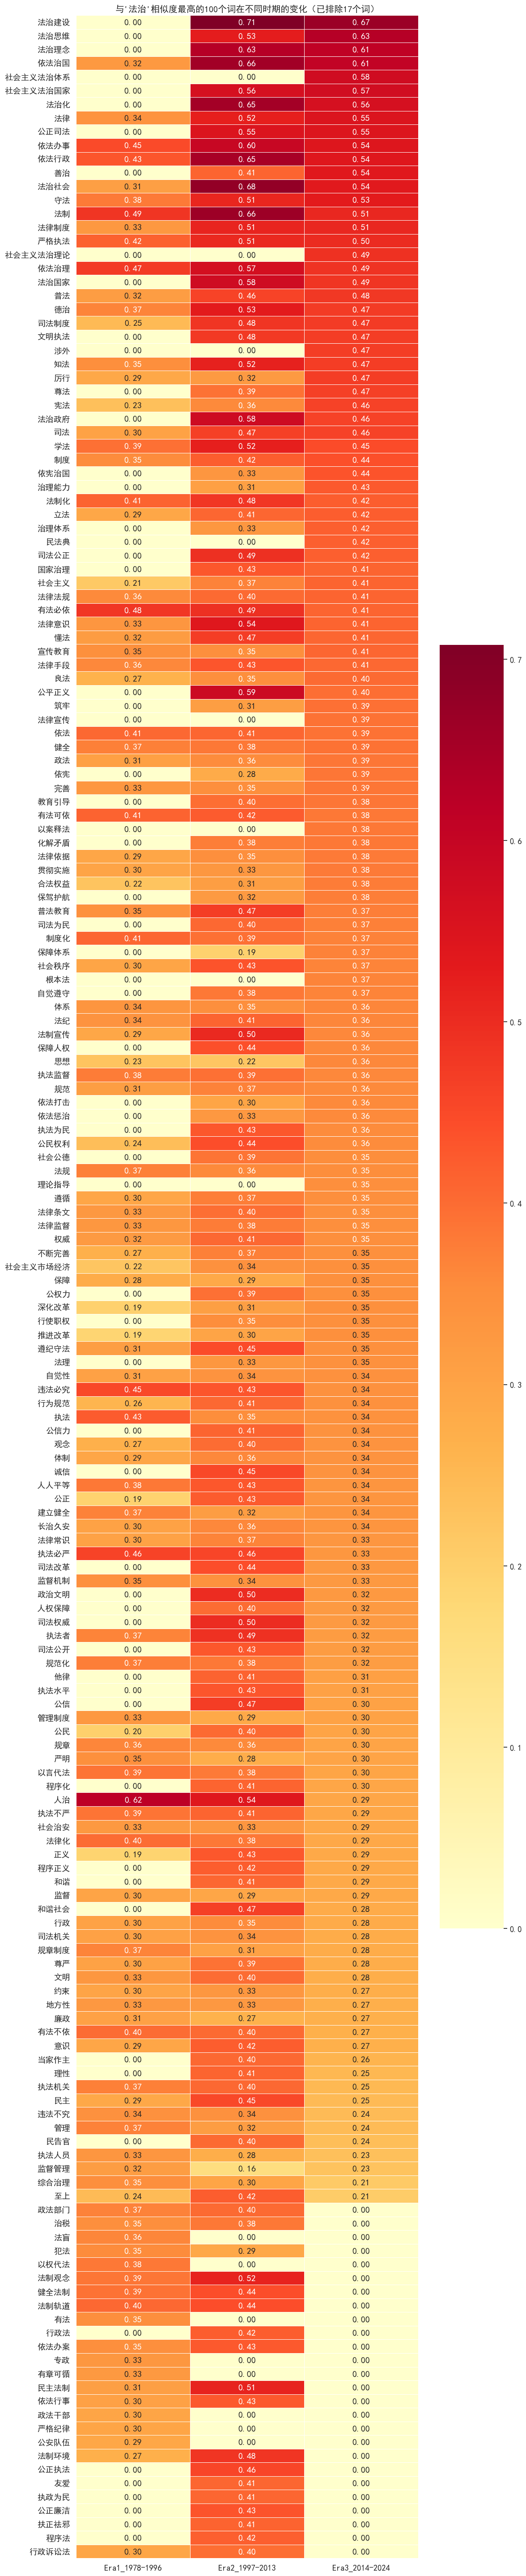

In [19]:
similarity_df = visualize_similar_words_across_periods(
    similar_words_by_period_union, 
    focus_word, 
    top_n=100, 
    exclude_words_path=exclude_words_path,
    normalize=False
)

In [3]:
def get_common_top_words(similar_words_by_period, top_n=50, exclude_words_path=None):
    """
    获取所有时期中前N个相似词的并集
    
    参数:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    top_n: 每个时期要考虑的前N个相似词
    exclude_words_path: 排除词库的文件路径，文件中每行一个词
    
    返回:
    common_words: 所有时期前N个相似词的并集
    filtered_similar_words: 过滤后的相似词字典
    """
    if not similar_words_by_period:
        print("没有数据可供分析")
        return [], {}
    
    # 加载排除词库
    exclude_words = set()
    if exclude_words_path:
        try:
            with open(exclude_words_path, 'r', encoding='utf-8') as f:
                exclude_words = set(line.strip() for line in f if line.strip())
            print(f"已加载 {len(exclude_words)} 个排除词")
        except Exception as e:
            print(f"加载排除词库时出错: {e}")
    
    # 准备数据
    periods = list(similar_words_by_period.keys())
    
    # 为每个时期过滤掉排除词
    filtered_similar_words = {}
    for period in periods:
        # 过滤掉排除词
        filtered_words = [(word, sim) for word, sim in similar_words_by_period[period] 
                         if word not in exclude_words]
        filtered_similar_words[period] = filtered_words
    
    # 获取每个时期前top_n个词的并集
    common_words = []
    for period in periods:
        top_words = [word for word, _ in filtered_similar_words[period][:top_n]]
        for word in top_words:
            if word not in common_words:  # 避免重复
                common_words.append(word)
    
    print(f"所有时期前{top_n}个相似词的并集包含 {len(common_words)} 个词")
    return common_words, filtered_similar_words

def visualize_relative_similarity(similar_words_by_period, focus_word, common_words, filtered_similar_words=None, top_n=30):
    """
    可视化不同时期相似词的相对相似度
    
    参数:
    similar_words_by_period: 字典，键为时期名称，值为(word, similarity)元组列表
    focus_word: 焦点词
    common_words: 所有时期前N个相似词的并集
    filtered_similar_words: 过滤后的相似词字典，如果为None则使用similar_words_by_period
    top_n: 最终要显示的词数量
    """
    if not similar_words_by_period:
        print("没有数据可供可视化")
        return
    
    # 如果没有提供过滤后的相似词，则使用原始相似词
    if filtered_similar_words is None:
        filtered_similar_words = similar_words_by_period
    
    # 准备数据
    periods = list(similar_words_by_period.keys())
    
    # 限制common_words的数量，以便更好地可视化
    if len(common_words) > top_n:
        # 计算每个词在所有时期的平均相似度
        word_avg_sim = {}
        for word in common_words:
            sims = []
            for period in periods:
                word_sim_dict = dict(filtered_similar_words[period])
                if word in word_sim_dict:
                    sims.append(word_sim_dict[word])
            if sims:
                word_avg_sim[word] = sum(sims) / len(sims)
        
        # 按平均相似度排序，取前top_n个词
        common_words = sorted(word_avg_sim.keys(), key=lambda w: word_avg_sim[w], reverse=True)[:top_n]
    
    # 创建一个DataFrame来存储每个时期每个词的相似度
    df_raw = pd.DataFrame(index=common_words, columns=periods)
    
    # 填充原始相似度DataFrame
    for period in periods:
        word_sim_dict = dict(filtered_similar_words[period])
        for word in common_words:
            df_raw.loc[word, period] = word_sim_dict.get(word, 0)
    
    # 确保所有值都是浮点数
    df_raw = df_raw.astype(float)
    
    # 计算相对相似度
    # 相对相似度 = 当前时期相似度 / 所有时期该词的最大相似度
    df_relative = pd.DataFrame(index=common_words, columns=periods)
    
    for word in common_words:
        max_sim = df_raw.loc[word].max()
        if max_sim > 0:  # 避免除以零
            for period in periods:
                df_relative.loc[word, period] = df_raw.loc[word, period] / max_sim
        else:
            for period in periods:
                df_relative.loc[word, period] = 0
    
    # 确保相对相似度DataFrame中的所有值都是浮点数
    df_relative = df_relative.astype(float)
    
    # 按照在最后一个时期的相对相似度排序
    if len(periods) > 0:
        last_period = periods[-1]
        df_relative = df_relative.sort_values(by=last_period, ascending=False)
    
    # 绘制热力图 - 原始相似度
    plt.figure(figsize=(12, len(common_words) * 0.3 + 2))
    sns.heatmap(df_raw, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
    plt.title(f"与'{focus_word}'的原始相似度 (共{len(common_words)}个词)")
    plt.tight_layout()
    plt.show()
    
    # 绘制热力图 - 相对相似度
    plt.figure(figsize=(12, len(common_words) * 0.3 + 2))
    sns.heatmap(df_relative, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, vmin=0, vmax=1)
    plt.title(f"与'{focus_word}'的相对相似度 (共{len(common_words)}个词)")
    plt.tight_layout()
    plt.show()
    
    return df_raw, df_relative

In [4]:
# 获取共同词集合
common_words, filtered_similar_words = get_common_top_words(
    similar_words_by_period, 
    top_n=100,  # 每个时期考虑前50个词
    exclude_words_path=exclude_words_path
)

# 可视化相对相似度
raw_df, relative_df = visualize_relative_similarity(
    similar_words_by_period,
    focus_word,
    common_words,
    filtered_similar_words,
    top_n=100  # 最终显示前30个词
)

NameError: name 'similar_words_by_period' is not defined